In [1]:
from modules.Functions import *

# want smaller than 1 (lattice spacing) to resolve elementary excitations
abs_m2 = 0.2

# enough room for some instantons
lattice_size = 32

Acceptance rate: 0.402
m^2 = -0.2, g = 0.2, v = 2.24
elementary mass = 0.632, rms displacement ~ 0.913
S_inst = 2.11
Final sample action: 14.7


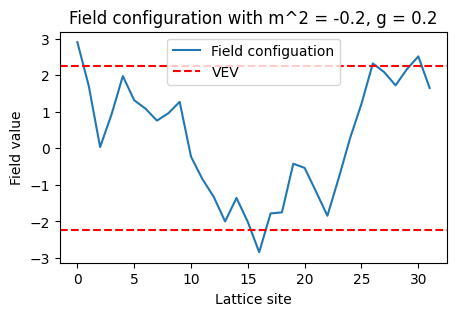

Estimated autocorrelation time: 68 (point), 41 (action)


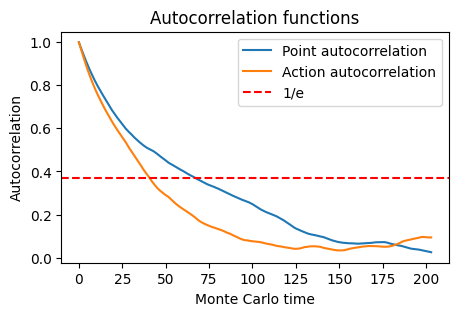

In [2]:
# m^2 / g (the dimensionless parameter)
m2g = -1

m2, g = get_m2_and_g(abs_m2, m2g)
x, samples_list = metropolis_algorithm(size=lattice_size, mc_iterations=16000, m2=m2, g=g)
print_and_plot(x, m2, g)
plot_autocorrelation(samples_list, m2, g)

Calculating autocorrelation times...
Acceptance rate: 0.12
Acceptance rate: 0.148


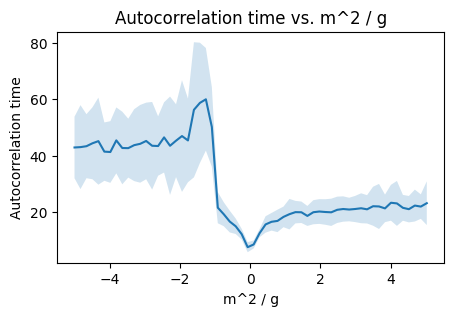

In [6]:
# find autocorrelation times, so know how long to run Monte Carlo for
# for quite negative m^2 / g, using peaked noise (otherwise don't get instantons -> large autocorrelation times)
# otherwise, flat noise is sufficient
num_chains = 64
plot_step = 0.17
m2gs = torch.arange(-5, 5 + plot_step, plot_step)

# get autocorrelation times for different m^2
times = torch.zeros(len(m2gs))
errors = torch.zeros(len(m2gs))
print("Calculating autocorrelation times...")
for i, m2g in enumerate(m2gs):
    m2, g = get_m2_and_g(abs_m2, m2g)

    ts = torch.tensor([action_autocorrelation(samples, m2=m2, g=g, only_time=True)[1] for samples in
            metropolis_algorithm2(size=lattice_size, mc_iterations=10000, m2=m2, g=g, quiet=True, num_chains=num_chains)], dtype=torch.float32)
    
    times[i] = torch.mean(ts)
    errors[i] = torch.std(ts)  # not of mean!!

plot(m2gs, times, xlabel='m^2 / g', ylabel='Autocorrelation time', title='Autocorrelation time vs. m^2 / g', y_errors=errors, ylog=False)

tensor([-1.2600, -1.4300, -1.6000])
Checking autocorrelation time for m^2 / g = -1.2599999904632568...


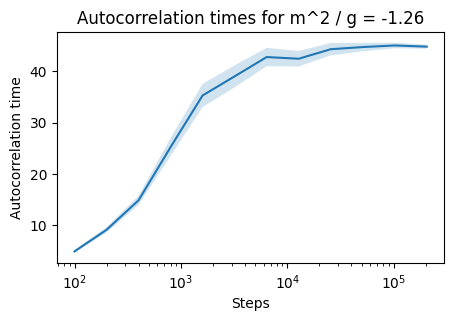

In [8]:
# check that autocorrelation time of action is estimated well by mc_iterations=10000 above
print(m2gs[times.topk(3).indices])
m2g = m2gs[times.topk(1).indices].item()
print(f'Checking autocorrelation time for m^2 / g = {m2g}...')
m2, g = get_m2_and_g(abs_m2, -2.41)

num_chains = 64
iterations_max = torch.tensor([100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 204800])
times_max = torch.zeros(len(iterations_max))
errors_max = torch.zeros(len(iterations_max))
samples_list = metropolis_algorithm2(size=lattice_size, mc_iterations=iterations_max[-1].item(), m2=m2, g=g, quiet=True, num_chains=num_chains)
for i, mc_iterations in enumerate(iterations_max):
    # not great but ok for now: ([:out_of_bounds] returns whole tensor)
    ts = torch.tensor([action_autocorrelation(samples[:mc_iterations//3], m2=m2, g=g, only_time=True)[1] for samples in samples_list], dtype=torch.float32)
    times_max[i] = torch.mean(ts)
    errors_max[i] = torch.std(ts) / math.sqrt(num_chains)

plot(iterations_max, times_max, xlabel='Steps', ylabel='Autocorrelation time', title=f'Autocorrelation times for m^2 / g = {m2g:.{sig_figs}g}', xlog=True, y_errors=errors_max)
    

Calculating action densities...
Acceptance rate: 0.121
Acceptance rate: 0.149


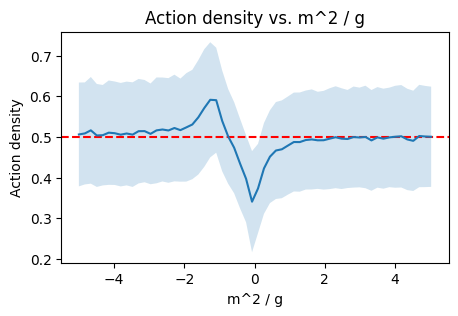

In [9]:
# plot the action density, notice the similarity to toy integral (see report)
num_chains = 64
min_samples_per_chain = 50

# find and plot the action density for each m^2
action_densities = torch.zeros(len(m2gs))
action_errors = torch.zeros(len(m2gs))
print("Calculating action densities...")
for i, m2g in enumerate(m2gs):
    m2, g = get_m2_and_g(abs_m2, m2g)

    samples = torch.cat(metropolis_algorithm2(size=lattice_size, mc_iterations=1, m2=m2, g=g, quiet=True, autocorrelation_time=times[i], min_samples=min_samples_per_chain, num_chains=num_chains))
    num_samples = samples.size(0)
    
    ads = action(samples, m2=m2, g=g) / lattice_size
    action_densities[i] = ads.mean()
    action_errors[i] = ads.std()  # not of mean!!

plot(m2gs, action_densities, xlabel='m^2 / g', ylabel='Action density', title='Action density vs. m^2 / g', y_errors=action_errors, horizontal_line=0.5)


In [913]:
%load_ext line_profiler
%lprun -f metropolis_algorithm2 metropolis_algorithm2(size=32, mc_iterations=16000, m2=-2, g=1, num_chains=100)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
Acceptance rate: 0.43


Timer unit: 1e-09 s

Total time: 3.12849 s
File: /var/folders/k5/w5h4wtf94f5c5tz1_j_30bgw0000gp/T/ipykernel_51735/3783565337.py
Function: metropolis_algorithm2 at line 118

Line #      Hits         Time  Per Hit   % Time  Line Contents
   118                                           def metropolis_algorithm2(size: int = 128, mc_iterations: int = 10000, m2: float = 1.0, g: float = 1.0, quiet: bool = False, autocorrelation_time: int = None, min_samples: int = 1, num_chains: int = 1):
   119                                               """
   120                                               Metropolis algorithm to generate 1D arrays of given size based on a probability distribution function p.
   121                                               
   122                                               Args:
   123                                               p (function): Probability distribution function.
   124                                               size (int): Length of the 1D 